## VQ-I2I Applications

We load and print the config.
This file is mostly inherited from VQGAN.

In [11]:
import os, random, torch
from omegaconf import OmegaConf
from taming_comb.modules.style_encoder.network import *
from taming_comb.modules.diffusionmodules.model import * 
from taming_comb.models.cond_transformer import * 
from dataset import dataset_single_enc_sty
from utils import get_rand_input, get_coord_idx, sample_gen, save_tensor, gen_uncond_indices
import numpy as np
from PIL import Image
import math

def show_image(s):
    s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
    s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
    s = Image.fromarray(s)
    display(s)

In [1]:
# seed
seed = 666
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


torch.cuda.empty_cache()

# set up global parameters
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print('device: ', device)
ne = 512  # Enlarge
ed = 512
z_channel = 256
codebook_size = 512
dataset = 'summer2winter_yosemite'
root_dir = '/eva_data0/dataset/summer2winter_yosemite'
first_stage_model = '/eva_data7/VQ-I2I/summer2winter_yosemite_512_512_settingc_256_final_test/settingc_latest.pt'
transformer_model = '/eva_data7/VQ-I2I/summer2winter_yosemite_512_512_transformer_final_test/n_700.pt'


# load first stage + second stage model
transformer_config = OmegaConf.load('transformer.yaml')
transformer_config.model.params.f_path = first_stage_model
transformer_config.model.params.first_stage_model_config.params.embed_dim = ed
transformer_config.model.params.first_stage_model_config.params.n_embed = ne
transformer_config.model.params.first_stage_model_config.params.ddconfig.z_channels = z_channel
transformer_config.model.params.device = str(device)
model = instantiate_from_config(transformer_config.model)
if(os.path.isfile(transformer_model)):
    print('load ' + transformer_model)
    ck = torch.load( transformer_model, map_location=device)
    model.load_state_dict(ck['model_state_dict'], strict=False)
model = model.to(device)
model.eval()
print('Finish Loading!')

if(os.path.isfile(transformer_model)):
    print('load ' + transformer_model)
    ck = torch.load( transformer_model, map_location=device)
    model.load_state_dict(ck['model_state_dict'], strict=False)
model = model.to(device)
model.eval()

print('Finish Loading!')

device:  cuda
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
load /eva_data7/VQ-I2I/summer2winter_yosemite_512_512_settingc_256_final_test/settingc_latest.pt
load /eva_data7/VQ-I2I/summer2winter_yosemite_512_512_transformer_final_test/n_700.pt
Finish Loading!
load /eva_data7/VQ-I2I/summer2winter_yosemite_512_512_transformer_final_test/n_700.pt
Finish Loading!


## Prepare data

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

In [3]:
latent_w = 28 # latent_w == 28 --> extends for 16*(latent_w-16) = 192px
coord_idx = get_coord_idx(model, device)

testA_set = dataset_single_enc_sty(root_dir, 'test', 'A', model.first_stage_model, device, flip=True) # flip enable 2-sided
testB_set = dataset_single_enc_sty(root_dir, 'test', 'B', model.first_stage_model, device, flip=True)

/home/mj/anaconda3/envs/setting-c/lib/python3.6/site-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/home/mj/anaconda3/envs/setting-c/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## Unconditional Generation

(1, 512, 16, 16)
Time: 6.078951597213745 seconds
Index: 32
Image Path: /eva_data0/dataset/summer2winter_yosemite/testA/2011-05-28 15:13:21.jpg


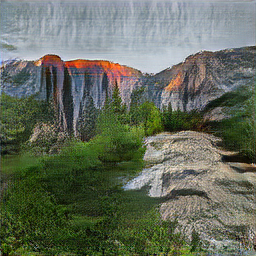

In [14]:
content_idx = gen_uncond_indices(model, device, target_code_size=16, codebook_size=codebook_size)
style_ref_img = testA_set[32]

test_samples = model.decode_to_img(content_idx, 
                      (1, codebook_size, content_idx.shape[1], content_idx.shape[2]),
                      style_ref_img['style'], style_ref_img['label'])
show_image(test_samples)

## Extension

(1, 512, 16, 28)
Time: 4.598255157470703 seconds


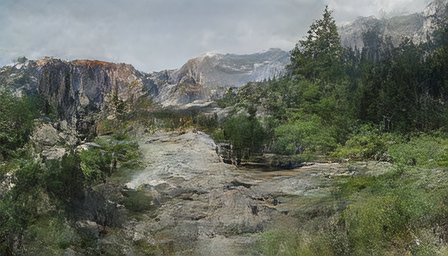

In [17]:
# right extension

# new_idx contains z_indices + random indices
new_idx = get_rand_input(device, content_idx, w=latent_w)
right_content_idx = sample_gen(new_idx, coord_idx, model, original_h=16, original_w=16, # original latent size 16x16
                z_code_shape=(1, codebook_size, 16, latent_w))

right_samples = model.decode_to_img(right_content_idx, 
                                (1, codebook_size, right_content_idx.shape[1], right_content_idx.shape[2]),
                                style_ref_img['style'], style_ref_img['label'])
show_image(right_samples)

torch.Size([1, 16, 16])
(1, 512, 16, 28)
Time: 4.646064043045044 seconds


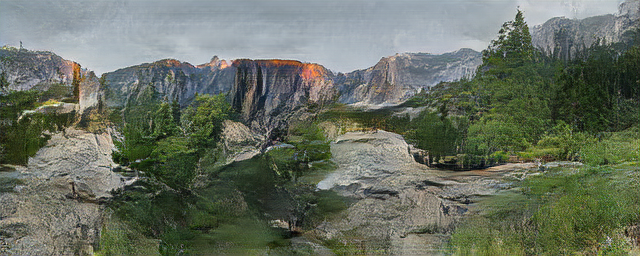

In [23]:
flip_content_idx = torch.flip(content_idx, [2])
print(flip_content_idx.shape)

# left extension
new_right_idx = get_rand_input(device, flip_content_idx, w=latent_w)
left_content_idx = sample_gen(new_right_idx, coord_idx, model, original_h=16, original_w=16, # original latent size 16x16
                z_code_shape=(1, codebook_size, 16, latent_w))

# left_samples = model.decode_to_img(left_content_idx, 
#                                 (1, codebook_size, left_content_idx.shape[1], left_content_idx.shape[2]),
#                                 style_ref_img['style'], style_ref_img['label'])
# show_image(torch.flip(left_samples, [3]))

## merge two-sided indices
two_sided_idx = torch.cat((left_content_idx[:, :, :left_content_idx.shape[2]-left_content_idx.shape[1]], right_content_idx), 2)
two_sided_samples = model.decode_to_img(two_sided_idx, 
                                (1, codebook_size, two_sided_idx.shape[1], two_sided_idx.shape[2]),
                                style_ref_img['style'], style_ref_img['label'])
show_image(two_sided_samples)    

## Translation
- We demonstrate both intra- and inter-domain translation.

Index: 72
Image Path: /eva_data0/dataset/summer2winter_yosemite/testA/2012-07-02 08:16:51.jpg


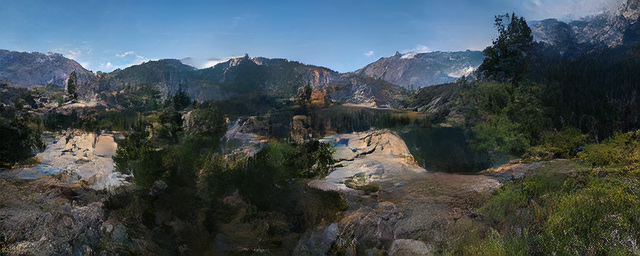

In [52]:
style_A = testA_set[72]
intra_samples = model.decode_to_img(two_sided_idx, 
                                (1, codebook_size, two_sided_idx.shape[1], two_sided_idx.shape[2]),
                                style_A['style'], style_A['label'])
show_image(intra_samples) 

Index: 204
Image Path: /eva_data0/dataset/summer2winter_yosemite/testB/2016-05-10 15:33:51.jpg


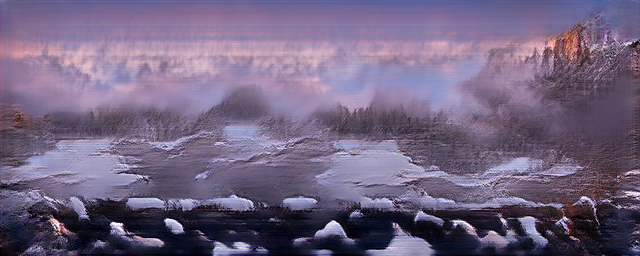

In [53]:
style_B = testB_set[204]
inter_samples = model.decode_to_img(two_sided_idx, 
                                (1, codebook_size, two_sided_idx.shape[1], two_sided_idx.shape[2]),
                                style_B['style'], style_B['label'])
show_image(inter_samples) 

## Transitional Stylization

In [51]:
def decode_entangle(index, zshape, style, label):
    with torch.no_grad():
        index = model.permuter(index, reverse=True)
        bhwc = (zshape[0],zshape[2],zshape[3],zshape[1])
        quant_z = model.first_stage_model.quantize.get_codebook_entry(
            index.reshape(-1), shape=bhwc)
        if label == 1:
            x = entangle_a(quant_z, style)
        else:
            x = entangle_b(quant_z, style)
        return x

def entangle_a(quant, style_a):
    with torch.no_grad():
        # decode content and style codes to an image
        model.first_stage_model.mlp_a = model.first_stage_model.mlp_a.to(style_a.device)
        adain_params = model.first_stage_model.mlp_a(style_a)
        model.first_stage_model.assign_adain_params(adain_params, model.first_stage_model.decoder_a)
        quant = model.first_stage_model.post_quant_conv(quant)

        dec = model.first_stage_model.decoder_a
        z = quant
        
        dec.last_z_shape = z.shape

        # z to block_in
        h = dec.conv_in(z)

        # AdaIN residual blocks
        dec.ADAresblocks = dec.ADAresblocks.to(h.device)
        h = dec.ADAresblocks(h)
        
        return h

    
def generate_a(h):
    with torch.no_grad():
        dec = model.first_stage_model.decoder_a
        
        # timestep embedding
        temb = None
        
        # middle
        h = dec.mid.block_1(h, temb)
        h = dec.mid.attn_1(h)
        h = dec.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(dec.num_resolutions)):
            for i_block in range(dec.num_res_blocks+1):
                h = dec.up[i_level].block[i_block](h, temb)
                if len(dec.up[i_level].attn) > 0:
                    h = dec.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = dec.up[i_level].upsample(h)

        # end
        if dec.give_pre_end:
            return h

        h = dec.norm_out(h)
        h = nonlinearity(h)
        h = dec.conv_out(h)
        return h
    

def entangle_b(quant, style_b):
    with torch.no_grad():
        # decode content and style codes to an image
        model.first_stage_model.mlp_b = model.first_stage_model.mlp_b.to(style_b.device)
        adain_params = model.first_stage_model.mlp_b(style_b)
        model.first_stage_model.assign_adain_params(adain_params, model.first_stage_model.decoder_b)
        quant = model.first_stage_model.post_quant_conv(quant)

        dec = model.first_stage_model.decoder_b
        z = quant
        
        dec.last_z_shape = z.shape

        # z to block_in
        h = dec.conv_in(z)

        # AdaIN residual blocks
        dec.ADAresblocks = dec.ADAresblocks.to(h.device)
        h = dec.ADAresblocks(h)
        
        return h

    
def generate_b(h):
    with torch.no_grad():
        dec = model.first_stage_model.decoder_b
        
        # timestep embedding
        temb = None
        
        # middle
        h = dec.mid.block_1(h, temb)
        h = dec.mid.attn_1(h)
        h = dec.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(dec.num_resolutions)):
            for i_block in range(dec.num_res_blocks+1):
                h = dec.up[i_level].block[i_block](h, temb)
                if len(dec.up[i_level].attn) > 0:
                    h = dec.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = dec.up[i_level].upsample(h)

        # end
        if dec.give_pre_end:
            return h

        h = dec.norm_out(h)
        h = nonlinearity(h)
        h = dec.conv_out(h)
        return h
        

Index: 138
Image Path: /eva_data0/dataset/summer2winter_yosemite/testA/2015-08-30 02:05:30.jpg
Index: 138
Image Path: /eva_data0/dataset/summer2winter_yosemite/testA/2015-08-30 02:05:30.jpg


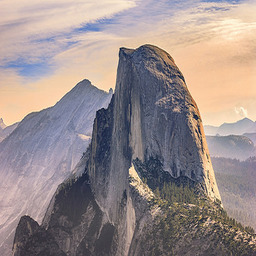

Index: 63
Image Path: /eva_data0/dataset/summer2winter_yosemite/testA/2016-07-24 23:14:50.jpg
Index: 63
Image Path: /eva_data0/dataset/summer2winter_yosemite/testA/2016-07-24 23:14:50.jpg


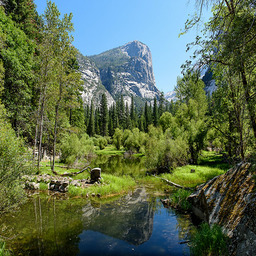

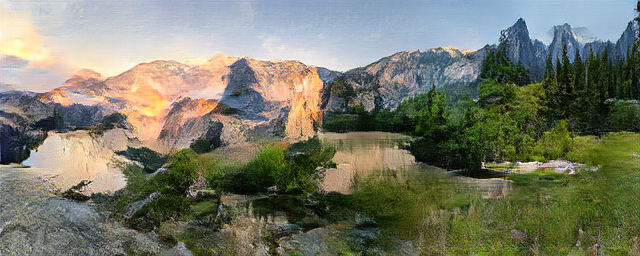

In [91]:
sty_num = 20 # split number
split_length = math.ceil(two_sided_idx.shape[-1] / sty_num)
splits = torch.split(two_sided_idx, split_length, dim=2)

sty1_idx = 138
sty2_idx = 63 # 280 137 78

sty1 = testA_set[sty1_idx]['style']
show_image(testA_set[sty1_idx]['image'])
sty2 = testA_set[sty2_idx]['style'] # good
show_image(testA_set[sty2_idx]['image'])

style_list = [] # save interpolated styles
for i in range(sty_num): # interpolation during the latent dimension
    style_list.append( (sty1 * (sty_num-1-i) + sty2 * i)/(sty_num-1) )

inter1_samples = model.decode_to_img(two_sided_idx, 
                                (1, codebook_size, two_sided_idx.shape[1], two_sided_idx.shape[2]),
                                sty1, 1)
inter2_samples = model.decode_to_img(two_sided_idx, 
                                (1, codebook_size, two_sided_idx.shape[1], two_sided_idx.shape[2]),
                                sty2, 1)

frac_list = []
for i in range(sty_num):
    # compose the content and style
    entan_part = decode_entangle(splits[i], (1, codebook_size, splits[i].shape[1], splits[i].shape[2]), style_list[i], 1)
    frac_list.append(split_img)
    if(i == 0): # first split
        out = entan_part
    else: # concate further splits
        out = torch.cat((out, entan_part), -1)

out_img = generate_a(out)
show_image(out_img)